### **Libraries**

In [2]:
#Loader
import pandas as pd
import matplotlib.pyplot as plt
from kloppy import pff

### **Data Loading**

In [3]:
# paths to data files
roster_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812_roster.json"
metadata_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812_metadata.json"
raw_data_path = "/home/student/Documents/AIMS/Intership/pysport/pysport-aims/first_week/data/3812/3812.jsonl.bz2"

In [4]:
# Load the dataset for match ID 3812.
dataset = pff.load_tracking(
    raw_data = raw_data_path,
    meta_data = metadata_path,
    roster_meta_data = roster_path,
    coordinates= "pff",
    limit= None,
    sample_rate= None
)

dataset.to_df().head(5)

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,13228_x,...,8033_d,8033_s,8326_x,8326_y,8326_d,8326_s,8327_x,8327_y,8327_d,8327_s
0,1,0 days 00:00:00,4226,alive,366,2.46,1.58,0.0,None,14.357,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.033041,4227,alive,366,2.04,1.62,0.0,None,14.335,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.066408,4228,alive,366,1.62,1.67,0.0,None,14.313,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:00.099774,4229,alive,366,1.20,1.71,0.0,None,14.291,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:00.133141,4230,alive,366,0.78,1.76,0.0,None,14.270,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


### **we rewrite here the code of the first animation using kloppy functionalities as most as we can**

In [5]:
# limit the frame to the 20s range on which we want to work on
selected_dataset = dataset.filter(lambda frame: (frame.timestamp.total_seconds() < 20) & (frame.period.id == 1))

# by this we conserve the dataset type by reduicing the number of frame to the ones we want.
print(type(selected_dataset),len(selected_dataset))

<class 'kloppy.domain.models.tracking.TrackingDataset'> 600


In [6]:
# from the limited dataset we can now extract first the dataframe of the ball coordinates first.
ball_coordinates = selected_dataset.to_df()[["frame_id","ball_x","ball_y"]]
ball_coordinates.head()

,frame_id,ball_x,ball_y
0,4226,2.46,1.58
1,4227,2.04,1.62
2,4228,1.62,1.67
3,4229,1.20,1.71
4,4230,0.78,1.76


In [7]:
# store the home and away team data
home_team, away_team = dataset.metadata.teams

In [8]:
# get the dataframe of the home team players

# first get the formated list of ids of the home players 
dims = ["x","y"]
home_player_ids = [f"{player.player_id}_{dim}" for dim in dims for player in home_team.players if f"{player.player_id}_{dim}" in selected_dataset.to_df().columns ]

# now get the sub dataframe of their positions
home_team_pos = selected_dataset.to_df()[["frame_id"]+home_player_ids]
home_team_pos.head()

,frame_id,7988_x,9993_x,214_x,3858_x,3903_x,13228_x,13901_x,3848_x,428_x,...,9993_y,214_y,3858_y,3903_y,13228_y,13901_y,3848_y,428_y,2059_y,474_y
0,4226,-0.771,19.462,9.501,7.011,2.879,14.357,7.543,18.819,1.351,...,3.407,-1.919,-8.378,11.588,18.306,4.958,-21.928,-22.141,-0.469,-4.934
1,4227,-0.833,19.431,9.478,6.947,2.851,14.335,7.527,18.782,1.333,...,3.434,-1.890,-8.298,11.637,18.322,4.993,-21.922,-22.092,-0.464,-4.912
2,4228,-0.895,19.401,9.455,6.883,2.823,14.313,7.512,18.746,1.315,...,3.460,-1.862,-8.218,11.685,18.338,5.028,-21.915,-22.045,-0.459,-4.890
3,4229,-0.957,19.370,9.432,6.820,2.796,14.291,7.497,18.710,1.298,...,3.486,-1.834,-8.140,11.733,18.353,5.063,-21.909,-21.998,-0.454,-4.867
4,4230,-1.019,19.339,9.409,6.757,2.768,14.270,7.481,18.674,1.280,...,3.511,-1.807,-8.062,11.780,18.368,5.097,-21.903,-21.952,-0.449,-4.845


In [9]:
# rotate to get the player_ids as a column the x position and the y position as a columns too
# Melt the dataframe
melted = home_team_pos.copy().reset_index().melt(id_vars='frame_id', var_name='player_coord', value_name='position')
# Split player_id and coordinate
melted[['player_id', 'coord']] = melted['player_coord'].str.extract(r'(\d+)_([xy])')
# Pivot so x and y are separate columns
home_rotated = melted.pivot_table(index=['frame_id', 'player_id'], columns='coord', values='position').reset_index()
# rename columns
home_rotated = home_rotated.rename(columns={'x': 'x_pos', 'y': 'y_pos'})
home_rotated.head()

coord,frame_id,player_id,x_pos,y_pos
0,4226,13228,14.357,18.306
1,4226,13901,7.543,4.958
2,4226,2059,42.184,-0.469
3,4226,214,9.501,-1.919
4,4226,3848,18.819,-21.928


In [10]:
# replication for the away tea player's
away_players_ids = [f"{player.player_id}_{dim_}" for dim_ in dims for player in away_team.players if f"{player.player_id}_{dim_}"in selected_dataset.to_df().columns ]
away_team_pos = selected_dataset.to_df()[["frame_id"]+away_players_ids]

# rotation 
away_melted = away_team_pos.copy().reset_index().melt(id_vars='frame_id', var_name='player_coord', value_name='position')
away_melted[['player_id', 'coord']] = away_melted['player_coord'].str.extract(r'(\d+)_([xy])')
away_rotated = away_melted.pivot_table(index=['frame_id', 'player_id'], columns='coord', values='position').reset_index()
away_rotated = away_rotated.rename(columns={'x': 'x_pos', 'y': 'y_pos'})
away_rotated.head()

coord,frame_id,player_id,x_pos,y_pos
0,4226,11094,1.247,-11.488
1,4226,11241,-30.699,-9.363
2,4226,1522,-11.375,1.698
3,4226,284,-21.746,14.948
4,4226,3315,2.461,1.580


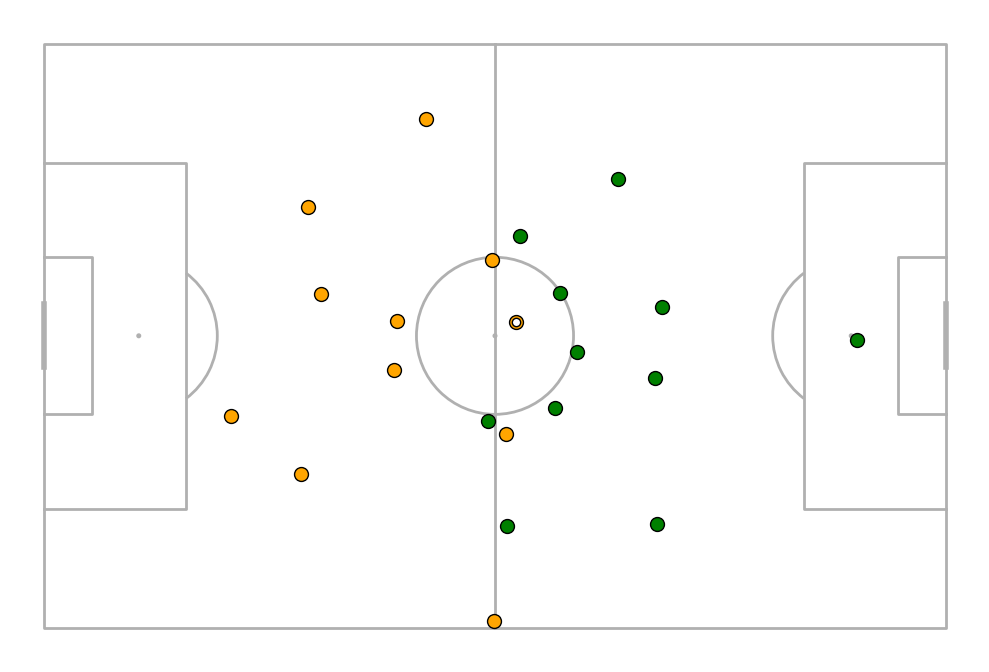

In [11]:
# then now I can plot the animation.
from mplsoccer import Pitch
from matplotlib import animation


pitch = Pitch(pitch_type='skillcorner', goal_type='line', pitch_width=68, pitch_length=105)
fig, ax = pitch.draw(figsize=(10, 7.4))

# then setup the pitch plot markers we want to animate
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away, = ax.plot([], [], ms=10, markerfacecolor='orange', **marker_kwargs)  
home, = ax.plot([], [], ms=10, markerfacecolor='green', **marker_kwargs) 

# animation function
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    # set the ball data with the x and y positions for the ith frame
    ball.set_data(ball_coordinates.iloc[i, [1]], ball_coordinates.iloc[i, [2]])
    # get the frame id for the ith frame
    frame = ball_coordinates.iloc[i, 0]
    # set the player data using the frame id
    away.set_data(away_rotated.loc[away_rotated.frame_id == frame, 'x_pos'],
                  away_rotated.loc[away_rotated.frame_id == frame, 'y_pos'])
    home.set_data(home_rotated.loc[home_rotated.frame_id == frame, 'x_pos'],
                  home_rotated.loc[home_rotated.frame_id == frame, 'y_pos'])
    return ball, away, home


# call the animator, animate so 25 frames per second
anim = animation.FuncAnimation(fig, animate, frames=len(ball_coordinates), interval=33, blit=True)

plt.show()


In [12]:
anim.save("animation2.mp4", fps=30, extra_args=['-vcodec', 'libx264'])

**Find the correct game in the event data that is the same as the game from the tracking data.**

In [15]:
# load the football world cup event data from statbomb
from kloppy import statsbomb
from statsbombpy import sb
import polars as pl 

matches = sb.matches(competition_id=43, season_id=106)
type(matches)


pandas.core.frame.DataFrame

In [16]:
condition = (((pl.col("home_team") == "Senegal") & (pl.col("away_team") == "Netherlands")) |((pl.col("away_team") == "Netherlands")& (pl.col("away_team") == "Senegal")))
sn_VS_pb = pl.from_pandas(matches).filter(condition)

In [17]:
sn_VS_pb

match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
i64,str,str,str,str,str,str,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str
3857285,"""2022-11-21""","""18:00:00.000""","""International - FIFA World Cup""","""2022""","""Senegal""","""Netherlands""",0,2,"""available""","""available""","""2023-06-03T18:25:09.879323""","""2023-06-20T10:37:16.264240""",1,"""Group Stage""","""Al Thumama Stadium""","""Wilton Pereira Sampaio""","""Aliou Cissé""","""Louis van Gaal""","""1.1.0""","""2""","""2"""


In [18]:
# now load the corresponding match.
# get the match id
match_id = sn_VS_pb["match_id"][0]

# oad the corresponding files
sn_VS_pb_df = statsbomb.load(
    event_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json",
    lineup_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/{match_id}.json",
    three_sixty_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json"
)
sn_VS_pb_df


<EventDataset record_count=3258>

**Figure out which team is playing in the game and then find the correct match id for the event data that corresponds to the tracking data**

In [20]:
# by the previous up to now what we did is to assume the name of the team we want to deal with and just load their data from the event dataset.
# assume now we just get the tracking data the best way is to get there directly the name of the teams and their ground to simplify the logic of the selection.
team_info = {
    "home_team_name": dataset.metadata.teams[0].name,
    "home_team_id": dataset.metadata.teams[0].team_id,
    "home_team_ground": dataset.metadata.teams[0].ground,
    "away_team_name":dataset.metadata.teams[1].name,
    "away_team_id": dataset.metadata.teams[1].team_id,
    "away_team_ground": dataset.metadata.teams[0].ground,
}

# test to read the values
team_info["home_team_name"]

'Senegal'

In [21]:
# by this we can now get a simplyfied request to get the event_data
condition_2 = ((pl.col("home_team") == team_info["home_team_name"]) & (pl.col("away_team") == team_info["away_team_name"]))
# then we can get the match_id in the set of provided match data and load it
match_id2 = pl.from_pandas(matches).filter(condition_2)["match_id"][0]

# load the corresponding files
sn_VS_pb_df = statsbomb.load(
    event_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id2}.json",
    lineup_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/{match_id2}.json",
    three_sixty_data=f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id2}.json"
)
sn_VS_pb_df

<EventDataset record_count=3258>

**Here you see that we didn't input manualy the name of the teams.**

In [22]:
# select only the event starting after the first pass on 20 s
first_twenty_sec = sn_VS_pb_df.filter(lambda event:((event.timestamp.total_seconds() > 0.21) & (event.timestamp.total_seconds() < 20) & (event.period.id == 1)))

In [23]:
first_twenty_sec.to_df(engine="polars")

event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,body_part_type,result,success
str,str,i64,duration[μs],duration[μs],str,str,str,str,f64,f64,f64,f64,str,str,str,str,bool
"""555d8141-1057-45f0-a665-1421d8…","""PASS""",1,225ms,1s 296089µs,"""alive""","""941""","""941""","""3264""",0.499564,0.499327,0.37932,0.441458,"""8118""","""KICK_OFF""","""RIGHT_FOOT""","""COMPLETE""",true
"""2579c34a-0d48-4fe0-b2f1-daea54…","""GENERIC:Ball Receipt*""",1,1s 296ms,null,"""alive""","""941""","""941""","""8118""",0.37932,0.441458,null,null,null,null,null,null,null
"""55487586-33e8-4947-8081-d05e0a…","""CARRY""",1,1s 296ms,3s 911958µs,"""alive""","""941""","""941""","""8118""",0.37932,0.441458,0.391156,0.418542,null,null,null,"""COMPLETE""",true
"""a6ae20d5-f259-4246-a3e3-3d1d6b…","""PASS""",1,3s 912ms,6s 30228µs,"""alive""","""941""","""941""","""8118""",0.391156,0.418542,0.404571,0.034487,"""3311""",null,"""RIGHT_FOOT""","""COMPLETE""",true
"""e6570720-747f-47d9-978f-170329…","""GENERIC:Ball Receipt*""",1,6s 30ms,null,"""alive""","""941""","""941""","""3311""",0.404571,0.034487,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""e52d5d41-6ac2-4512-87c2-57388a…","""GENERIC:Ball Receipt*""",1,13s 418ms,null,"""alive""","""941""","""941""","""3669""",0.228599,0.581458,null,null,null,null,null,null,null
"""ff52683f-b35f-4579-8d72-115aea…","""CARRY""",1,13s 418ms,14s 863147µs,"""alive""","""941""","""941""","""3669""",0.228599,0.581458,0.228599,0.581458,null,null,null,"""COMPLETE""",true
"""893412b8-c70f-46cb-9b27-9912dc…","""PASS""",1,14s 863ms,16s 472056µs,"""alive""","""941""","""941""","""3669""",0.228599,0.581458,0.277524,0.285086,"""3306""",null,"""RIGHT_FOOT""","""COMPLETE""",true


### **Good by this we have the list of the event in the first twenty second**

In [24]:
# from the prior script we know that the ball owning team in the first twenty second is the NeitherLand let check. 
team_names = [event.ball_owning_team.name for event in first_twenty_sec]

def all_equal(lst):
    return (all(x == lst[0] for x in lst),lst[0])

print(all_equal(team_names))

(True, 'Netherlands')


In [25]:
# change the coordinates system.
from kloppy.domain import Provider
first_twenty_sec = first_twenty_sec.transform(to_coordinate_system=Provider.SKILLCORNER)
first_twenty_sec.metadata.coordinate_system

In [26]:
event_names = [event.event_name for event in first_twenty_sec]
event_names

['pass',
 'Ball Receipt*',
 'carry',
 'pass',
 'Ball Receipt*',
 'carry',
 'pass',
 'Ball Receipt*',
 'pass',
 'Ball Receipt*',
 'carry',
 'pass',
 'Ball Receipt*',
 'carry',
 'pass',
 'Ball Receipt*',
 'carry']

In [ ]:
first_twenty_sec

<EventDataset record_count=17>

In [29]:
len(first_twenty_sec.find_all("generic"))

6

In [ ]:
# we don't care about the carry.

# only the pass
passes = first_twenty_sec.filter(lambda event: "pass" in event.event_name)
# only the pass receipt.
receipts = first_twenty_sec.filter(lambda event: "Receipt" in event.event_name)

# By this we get event_data instead to lists we can get by using complex patern matching or find_all() method.
# The intention behind is to plot differently each type of event.

passes.to_df()

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,set_piece_type,body_part_type,result,success
0,555d8141-1057-45f0-a665-1421d851d17d,PASS,1,0 days 00:00:00.225000,0 days 00:00:01.296089,alive,941,941,3264,-0.045750,0.045750,-12.671429,3.980833,8118,KICK_OFF,RIGHT_FOOT,COMPLETE,True
1,a6ae20d5-f259-4246-a3e3-3d1d6b53fccb,PASS,1,0 days 00:00:03.912000,0 days 00:00:06.030228,alive,941,941,8118,-11.428571,5.539167,-10.020000,31.654889,3311,None,RIGHT_FOOT,COMPLETE,True
2,c412b31f-bff5-46a9-b772-07b7f7e82552,PASS,1,0 days 00:00:07.008000,0 days 00:00:08.289287,alive,941,941,3311,-10.020000,31.424222,-9.357143,18.005833,8118,None,LEFT_FOOT,COMPLETE,True
3,43a24cbf-fa90-45c4-b594-210d3ece2cd1,PASS,1,0 days 00:00:08.289000,0 days 00:00:09.499973,alive,941,941,8118,-9.357143,18.005833,-23.857143,20.022500,3306,None,RIGHT_FOOT,COMPLETE,True
4,6cc97331-5a0d-4446-8dda-d3441061f68d,PASS,1,0 days 00:00:11.809000,0 days 00:00:13.418061,alive,941,941,3306,-23.360000,17.547500,-28.497143,-5.539167,3669,None,LEFT_FOOT,COMPLETE,True
5,893412b8-c70f-46cb-9b27-9912dc337890,PASS,1,0 days 00:00:14.863000,0 days 00:00:16.472056,alive,941,941,3669,-28.497143,-5.539167,-23.360000,14.614167,3306,None,RIGHT_FOOT,COMPLETE,True


In [30]:
# build the dataframe of events coordinates and frame_id of the frame on which the events appears
event_dic = {
    "time_stamp":[event.timestamp for event in first_twenty_sec],
    "event_type":[event.event_name for event in first_twenty_sec],
    "x_pos":[event.coordinates.x for event in first_twenty_sec],
    "y_pos":[event.coordinates.y for event in first_twenty_sec]
}
pd.DataFrame(event_dic)


,time_stamp,event_type,x_pos,y_pos
0,0 days 00:00:00.225000,pass,-0.045750,0.045750
1,0 days 00:00:01.296000,Ball Receipt*,-12.671429,3.980833
2,0 days 00:00:01.296000,carry,-12.671429,3.980833
3,0 days 00:00:03.912000,pass,-11.428571,5.539167
4,0 days 00:00:06.030000,Ball Receipt*,-10.020000,31.654889
5,0 days 00:00:06.030000,carry,-10.020000,31.654889
6,0 days 00:00:07.008000,pass,-10.020000,31.424222
7,0 days 00:00:08.289000,Ball Receipt*,-9.357143,18.005833
8,0 days 00:00:08.289000,pass,-9.357143,18.005833
9,0 days 00:00:09.500000,Ball Receipt*,-23.857143,20.022500


In [46]:
# another way to get the dataframe using kloppy functionalities
# for passes
df_passes = passes.to_df("timestamp","event_type","coordinates_*",engine="polars" )
# for receipt
df_receipt = receipts.to_df("timestamp","event_type","coordinates_*",engine="polars")
df_receipt

timestamp,event_type,coordinates_x,coordinates_y
duration[μs],str,f64,f64
1s 296ms,"""GENERIC:Ball Receipt*""",-12.671429,3.980833
6s 30ms,"""GENERIC:Ball Receipt*""",-10.02,31.654889
8s 289ms,"""GENERIC:Ball Receipt*""",-9.357143,18.005833
9s 500ms,"""GENERIC:Ball Receipt*""",-23.857143,20.0225
13s 418ms,"""GENERIC:Ball Receipt*""",-28.497143,-5.539167
16s 472ms,"""GENERIC:Ball Receipt*""",-23.36,14.614167


In [52]:
df_passes

timestamp,event_type,coordinates_x,coordinates_y
duration[μs],str,f64,f64
225ms,"""PASS""",-0.04575,0.04575
3s 912ms,"""PASS""",-11.428571,5.539167
7s 8ms,"""PASS""",-10.02,31.424222
8s 289ms,"""PASS""",-9.357143,18.005833
11s 809ms,"""PASS""",-23.36,17.5475
14s 863ms,"""PASS""",-28.497143,-5.539167


In [59]:
# good now we have to add a column which correspond on the exact frame_id in the tracking dataset where the event occurs

# intution: get on the tracking dataset the frame at the timestamp up here.
passes_time_stamps  = [tt.total_seconds() * 1_000_000 for tt in list(df_passes["timestamp"])]
receipt_time_stamp = [tt.total_seconds() * 1_000_000 for tt in list(df_receipt["timestamp"])]

wide_range_corresponding = selected_dataset.filter(lambda frame: ((frame.timestamp.total_seconds() * 1_000_000 >= time_stamps[0]) & (frame.timestamp.total_seconds() * 1_000_000 <= time_stamps[-1]) & (frame.period.id ==1)))
len(wide_range_corresponding)

439

In [34]:
wide_range_corresponding.to_df(engine="polars")

period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,13228_x,13228_y,13228_d,13228_s,13901_x,13901_y,13901_d,13901_s,2059_x,2059_y,2059_d,2059_s,214_x,214_y,214_d,214_s,3848_x,3848_y,3848_d,3848_s,3858_x,3858_y,3858_d,3858_s,3903_x,3903_y,3903_d,3903_s,…,11241_s,1522_x,1522_y,1522_d,1522_s,284_x,284_y,284_d,284_s,3315_x,3315_y,3315_d,3315_s,37_x,37_y,37_d,37_s,8026_x,8026_y,8026_d,8026_s,8034_x,8034_y,8034_d,8034_s,8045_x,8045_y,8045_d,8045_s,8134_x,8134_y,8134_d,8134_s,84_x,84_y,84_d,84_s
i64,duration[μs],i64,str,str,f64,f64,f64,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,…,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null,f64,f64,null,null
1,233241µs,4233,"""alive""","""366""",-0.49,1.89,0.0,null,14.206,18.41,null,null,7.435,5.198,null,null,42.112,-0.435,null,null,9.339,-1.73,null,null,18.569,-21.886,null,null,6.568,-7.833,null,null,2.687,11.919,null,null,…,null,-11.282,2.018,null,null,-21.749,15.156,null,null,2.862,1.441,null,null,-20.455,4.742,null,null,-8.02,25.37,null,null,-11.597,-3.909,null,null,-22.531,-16.169,null,null,-0.039,-33.206,null,null,0.075,8.986,null,null
1,266608µs,4234,"""alive""","""366""",-0.91,1.93,0.0,null,14.185,18.423,null,null,7.419,5.23,null,null,42.102,-0.431,null,null,9.316,-1.705,null,null,18.534,-21.881,null,null,6.506,-7.758,null,null,2.661,11.964,null,null,…,null,-11.269,2.062,null,null,-21.75,15.185,null,null,2.92,1.422,null,null,-20.48,4.73,null,null,-8.024,25.395,null,null,-11.575,-3.892,null,null,-22.515,-16.183,null,null,-0.026,-33.205,null,null,0.131,9.005,null,null
1,299975µs,4235,"""alive""","""366""",-1.33,1.98,0.0,null,14.164,18.437,null,null,7.404,5.262,null,null,42.092,-0.426,null,null,9.293,-1.68,null,null,18.5,-21.875,null,null,6.443,-7.683,null,null,2.634,12.009,null,null,…,null,-11.257,2.106,null,null,-21.751,15.213,null,null,2.978,1.403,null,null,-20.505,4.718,null,null,-8.029,25.42,null,null,-11.553,-3.875,null,null,-22.499,-16.198,null,null,-0.014,-33.205,null,null,0.187,9.025,null,null
1,333341µs,4236,"""alive""","""366""",-1.75,2.02,0.0,null,14.143,18.449,null,null,7.388,5.294,null,null,42.082,-0.422,null,null,9.269,-1.657,null,null,18.467,-21.87,null,null,6.381,-7.609,null,null,2.608,12.054,null,null,…,null,-11.245,2.148,null,null,-21.753,15.241,null,null,3.036,1.383,null,null,-20.53,4.706,null,null,-8.033,25.444,null,null,-11.532,-3.858,null,null,-22.484,-16.213,null,null,-0.001,-33.204,null,null,0.243,9.044,null,null
1,366708µs,4237,"""alive""","""366""",-2.17,2.06,0.0,null,14.123,18.462,null,null,7.372,5.325,null,null,42.073,-0.418,null,null,9.246,-1.633,null,null,18.433,-21.864,null,null,6.318,-7.536,null,null,2.582,12.098,null,null,…,null,-11.233,2.191,null,null,-21.755,15.27,null,null,3.095,1.364,null,null,-20.554,4.694,null,null,-8.038,25.469,null,null,-11.51,-3.841,null,null,-22.469,-16.228,null,null,0.011,-33.203,null,null,0.299,9.063,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,16s 315991µs,4715,"""alive""","""366""",-23.39,14.62,0.0,null,4.193,20.467,null,null,0.254,10.499,null,null,36.42,-0.894,null,null,-2.929,-2.016,null,null,6.133,-20.141,null,null,-7.507,7.149,null,null,-9.09,16.634,null,null,…,null,-4.562,14.597,null,null,-23.388,14.618,null,null,8.113,-6.302,null,null,-27.461,-1.872,null,null,-6.935,31.483,null,null,-8.537,-3.72,null,null,-15.52,-22.746,null,null,-3.73,-32.572,null,null,7.303,9.052,null,null
1,16s 349357µs,4716,"""alive""","""366""",-23.34,14.65,0.0,null,4.171,20.528,null,null,0.273,10.549,null,null,36.429,-0.867,null,null,-2.873,-1.953,null,null,6.161,-20.11,null,null,-7.475,7.188,null,null,-9.075,16.693,null,null,…,null,-4.547,14.606,null,null,-23.344,14.654,null,null,8.131,-6.259,null,null,-27.441

In [71]:

# I write a function to get the most closer timestamp to a one I have from a list of time_stamp
def check(time_stamps,list_time_stamp):
    min,max = None,None
    if list_time_stamp[0] < time_stamps and list_time_stamp[-1] > time_stamps:
        max,min = list_time_stamp[0] , list_time_stamp[-1]
        i = 1
        while max < time_stamps:
            min = list_time_stamp[i]
            i += 1
        
        i = 1
        while min > time_stamps:
            max = list_time_stamp[-1-i]
            i += 1
    elif  list_time_stamp[0] > time_stamps:
        max = list_time_stamp[0]  
    elif list_time_stamp[-1] < time_stamps:
        min = list_time_stamp[-1] 
    return (min,max)

In [72]:
# now let try to get the closest timestamp to the list of timestamp of each type of event
list(wide_range_corresponding.to_df()["timestamp"].apply(lambda x: x.total_seconds() * 1000000))

[233241.0,
 266608.0,
 299975.0,
 333341.0,
 366708.0,
 400075.0,
 433441.0,
 466808.0,
 500175.00000000006,
 533542.0,
 566908.0,
 600275.0,
 633642.0,
 667008.0,
 700375.0,
 733742.0,
 767108.0,
 800475.0,
 833842.0,
 867209.0,
 900575.0,
 933942.0,
 967309.0,
 1000675.0,
 1034041.9999999999,
 1067409.0,
 1100775.0,
 1134142.0,
 1167509.0,
 1200876.0,
 1234242.0,
 1267609.0,
 1300976.0,
 1334342.0,
 1367709.0,
 1401076.0,
 1434442.0,
 1467809.0,
 1501176.0,
 1534543.0,
 1567909.0,
 1601276.0,
 1634643.0,
 1668009.0,
 1701376.0,
 1734743.0,
 1768109.0,
 1801476.0,
 1834843.0,
 1868210.0,
 1901576.0,
 1934943.0,
 1968310.0,
 2001675.9999999998,
 2035043.0,
 2068410.0,
 2101776.0,
 2135143.0000000005,
 2168510.0,
 2201877.0,
 2235243.0,
 2268610.0,
 2301977.0,
 2335343.0,
 2368710.0,
 2402077.0000000005,
 2435443.0000000005,
 2468810.0,
 2502177.0,
 2535544.0,
 2568910.0,
 2602277.0,
 2635644.0,
 2669010.0,
 2702377.0000000005,
 2735744.0,
 2769110.0,
 2802477.0,
 2835844.0,
 2869211.0,

In [77]:
# Convert all timestamps in wide_range_corresponding to microseconds
timestamps_us = list(
    wide_range_corresponding.to_df()["timestamp"].dt.total_seconds() * 1_000_000
)

# Now loop over each time_stamps in passes_time_stamps
results = []
for time_stamps in passes_time_stamps:
    # Run your check function with time_stamps and the converted timestamps
    check_result = check(time_stamps, timestamps_us)
    
    # Process each check_ value through snd()
    for check_ in check_result:
        results.append(check_)

IndexError: list index out of range